<a href="https://colab.research.google.com/github/liuxiao916/Dive_into_DL_PyTorch/blob/main/3_12_%E6%9D%83%E9%87%8D%E8%A1%B0%E5%87%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3.12 权重衰减

### 3.12.2 高纬线性回归实验

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
from IPython import display
from matplotlib import pyplot as plt

n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.mm(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

### 3.12.3 从零开始实验

1. 初始化参数模型

In [2]:
def init_params():
    w = torch.from_numpy(np.random.normal(scale=1, size = (num_inputs,1)))
    b = torch.zeros(1, requires_grad=True)
    w = w.float()
    b = b.float()
    w.requires_grad = True
    b.requires_grad = True
    return [w,b]

2. 定义L2范数惩罚项

In [3]:
def l2_penalty(w):
    return (w**2).sum()/2

3. 定义训练和测试

In [4]:
def linreg(X,w,b):
    return torch.mm(X,w)+b

In [5]:
def square_loss(y_hat,y):
    return (y_hat - y.view(y_hat.shape))**2/2

In [6]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data = param.data - lr*param.grad / batch_size

In [7]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [8]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5,2.5)):
    use_svg_display()
    #设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

In [11]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = linreg, square_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X, w, b),y) + lambd*l2_penalty(w)
            l.backward()
            sgd([w,b], lr, batch_size)
            w.grad.data.zero_()
            b.grad.data.zero_()
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())


4. 观察过拟合

L2 norm of w: 13.791402816772461


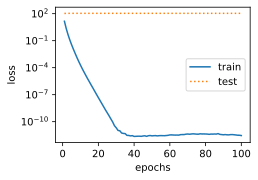

In [12]:
fit_and_plot(lambd=0)

5. 使用权重衰减

L2 norm of w: 0.03438129276037216


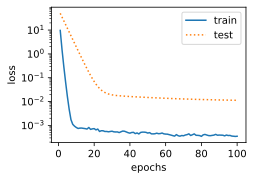

In [13]:
fit_and_plot(lambd=3)

### 3.12.4 简洁实现

In [25]:
def fit_and_plot_simply(wd):
    net = nn.Linear(num_inputs, 1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X),y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.backward()
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())

L2 norm of w: 0.5432257056236267


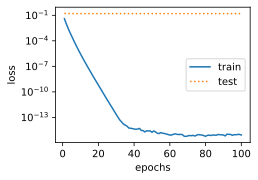

In [26]:
fit_and_plot_simply(0)

L2 norm of w: 0.033003248274326324


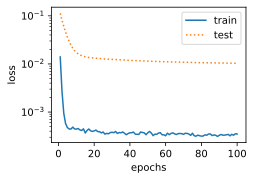

In [27]:
fit_and_plot_simply(3)